![image.png](agents_files/attach_0_image.png)

# LLM Tool/Function Calling

*Function calling is the ability to reliably connect LLMs to external tools to enable effective tool usage and interaction with external APIs.*

This is often a fine-tuned feature, not available to all models, but super useful where it is!

### Relevance

Andrew Ng and his team performed the following analysis:
![image-2.png](agents_files/attach_0_image-2.png)

### Common use cases

Function calling allows you to more reliably get structured data back from the model. For example, you can:

* Create assistants that answer questions by calling external APIs
     * e.g. define functions like `send_email(to: string, body: string)`, or `get_current_weather(location: string, unit: 'celsius' | 'fahrenheit')`
* Convert natural language into API calls
     * e.g. convert "Who are my top customers?" to `get_customers(min_revenue: int, created_before: string, limit: int)` and call your internal API
* Extract structured data from text
     * e.g. define a function called `extract_data(name: string, birthday: string)`, or `sql_query(query: string)`
 
### The basic sequence of steps for function calling is as follows:

1. Call the model with the user query and a set of functions defined in the functions parameter.
2. The model can choose to call one or more functions; if so, the content will be a stringified JSON object adhering to your custom schema
3. Parse the string into JSON in your code, and call your function with the provided arguments if they exist.
4. Call the model again by appending the function response as a new message, and let the model summarize the results back to the user.

While the name implies that the model is performing some action, this is actually not the case! The model is coming up with the arguments to a tool, and actually running the tool (or not) is up to the user
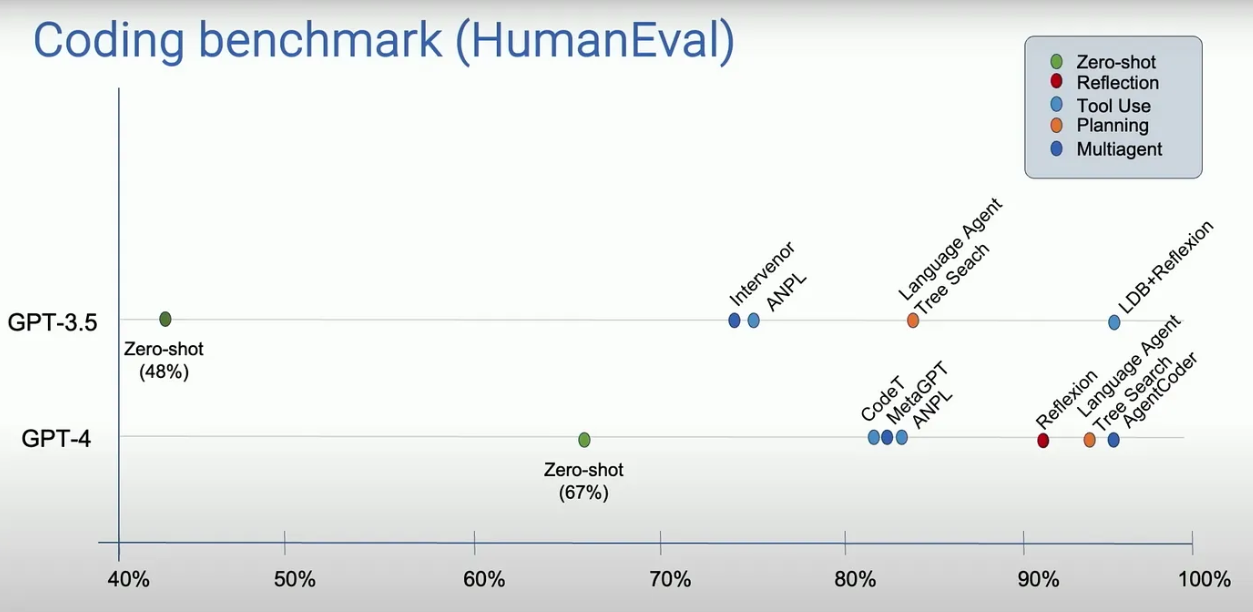
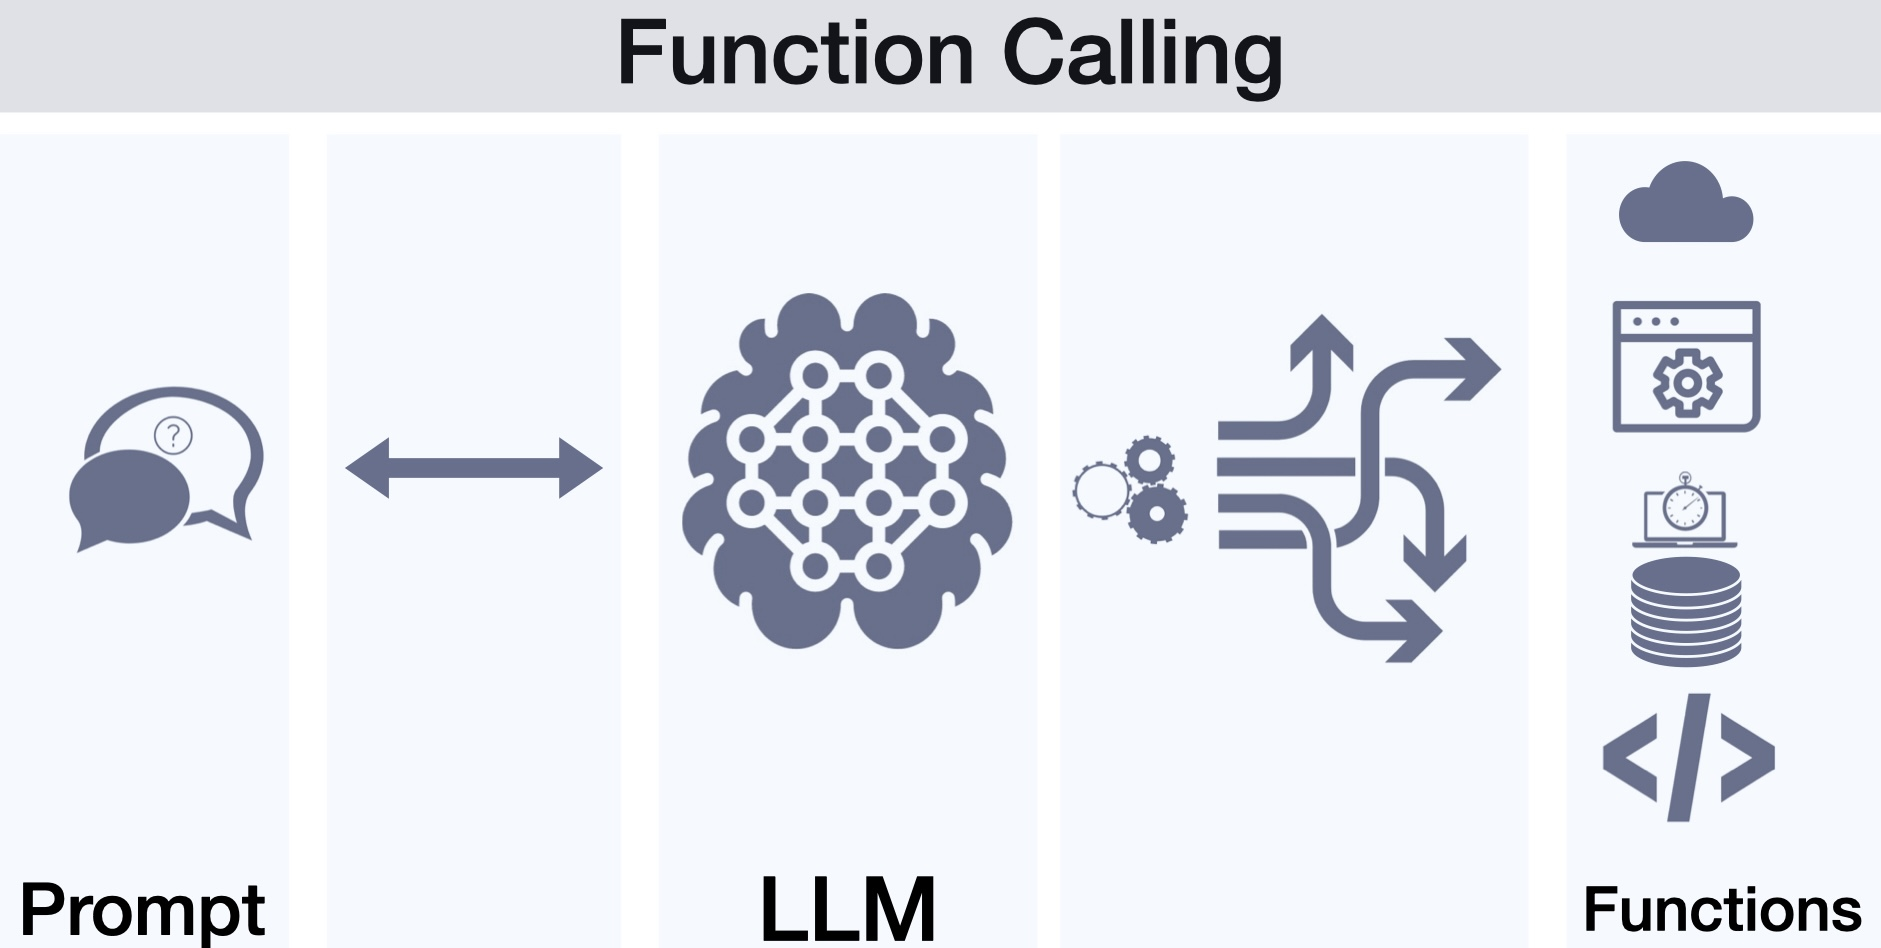

---
# Creating LLM Functions

## OpenAI Function Schema

**[OpenAI Function Calling Documentation](https://platform.openai.com/docs/guides/function-calling)**

*According to the JSON standard, a JSON value is one of the following JSON-language data types: object, array, number, string, Boolean (value true or false), or null (value null). All values except objects and arrays are scalar.*

https://en.wikipedia.org/wiki/JSON#Data_types

In [13]:
first_tools = [
        # Tool 1 - Get Exchange Rate
        { 
            "type": "function",
            "function": {
                "name": "get_exchange_rate",
                "description": "Get the current exchange rate of a base currency and target currency",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "base_currency": {
                            "type": "string",
                            "description": "The base currency for exchange rate calculations, i.e. USD, EUR, RUB",
                        },
                        "target_currency": {
                            "type": "string", 
                            "description": "The target currency for exchange rate calculations, i.e. USD, EUR, RUB"
                        },
                        "date": {
                            "type": "string", 
                            "description": "A specific day to reference, in YYYY-MM-DD format."
                        },
                    },
                    "required": ["base_currency", "target_currency"],
                },
            },
        },
        # Tool 2 - Search Internet
        { 
            "type": "function",
            "function": {
                "name": "search_internet",
                "description": "Get internet search results for real time information",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "search_query": {
                            "type": "string",
                            "description": "The query to search the web for",
                        }
                    },
                    "required": ["search_query"],
                },
            },
        }
    ]

In [23]:
from openai import AzureOpenAI
import json
from dotenv import load_dotenv

load_dotenv()
AZURE_OPENAI_API_KEY=os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT=os.getenv("AZURE_OPENAI_ENDPOINT")
MODEL_NAME = "gpt-35-turbo"

client = AzureOpenAI(
    api_version="2024-02-01",
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT
)

messages = [{"role": "user", 
             "content": "How much is a dollar worth in Japan? How about poland? Whats the current news in Argentina?"}]


response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        tools=first_tools,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )

In [24]:
# Function for printing out responses neatly
def pprint_response(response):
    print("--- Full Response ---\n")
    print(response, "\n")
    
    print("--- Chat Completion Message ---\n")
    print(response.choices[0].message, "\n")
    
    if response.choices[0].message.tool_calls:
        for i in range(0, len(response.choices[0].message.tool_calls)):
            print(f"--- Tool Call {i+1} ---\n")
            print(f"Function: {response.choices[0].message.tool_calls[i].function.name}\n")
            print(f"Arguments: {response.choices[0].message.tool_calls[i].function.arguments}\n")

In [25]:
pprint_response(response)

--- Full Response ---

ChatCompletion(id='chatcmpl-AN6v0wwrYw3JyGkcVt0EF84Y847Z0', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QNZCJGHsnbhsVL210F9tvtFG', function=Function(arguments='{\n  "base_currency": "USD",\n  "target_currency": "JPY"\n}', name='get_exchange_rate'), type='function')]), content_filter_results={})], created=1730071502, model='gpt-35-turbo', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=26, prompt_tokens=171, total_tokens=197), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}

---
## Executing the Functions

As the LLM is just populating the arguments for calling the function, it is up to us to actually execute the functions.

For our Web Search tool, we'll be using the DuckDuckGo API: https://pypi.org/project/duckduckgo-search/  
And for our Currency Conversion, we'll be using the Free Currency Exchange API: https://github.com/fawazahmed0/exchange-api

In [26]:
from duckduckgo_search import DDGS
import requests

def search_internet(search_query: str) -> list:
    results = DDGS().text(str(search_query), max_results=5)
    return results

def get_exchange_rate(base_currency: str, target_currency: str, date: str = "latest") -> float:
    
    url = f"https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@{date}/v1/currencies/{base_currency.lower()}.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data.get(base_currency.lower(), {}).get(target_currency.lower(), None)
    else:
        raise Exception(f"Failed to fetch exchange rate: {response.status_code}")

In [28]:
import inspect

# Main conversation function
def run_conversation(prompt, tools, tool_choice = "auto"):
    
    messages = [{"role": "user", "content": prompt}]
    
    print("\nInitial Message: ", messages)
    
    # Send the conversation and available functions to the model
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        tools=tools,
        tool_choice=tool_choice,
    )
    response_message = response.choices[0].message
    print("\nResponse Message: ", response_message)
    
    tool_calls = response_message.tool_calls
    print("\nTool Calls: ", tool_calls)
    
    # Check if the model wanted to call a function
    if tool_calls:
        
        # Call the functions
        available_functions = {
            "get_exchange_rate": get_exchange_rate,
            "search_internet": search_internet,
        } 
        # extend conversation with assistant's reply
        messages.append(response_message)
        
        # Call the function and add the response
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            
            
            # Get the function signature and call the function with given arguments
            sig = inspect.signature(function_to_call)
            call_args = {
                k: function_args.get(k, v.default)
                for k, v in sig.parameters.items()
                if k in function_args or v.default is not inspect.Parameter.empty
            }
            print(f"\nCalling {function_to_call} with arguments {call_args}")
            
            function_response = str(function_to_call(**call_args))
            
            print("\nFunction Response: ", function_response)

            # Put output into a tool message
            tool_message = {
                    "tool_call_id": tool_call.id, # Needed for Parallel Tool Calling
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            print("\nAppending Message: ", tool_message)
            
            # Extend conversation with function response
            messages.append(tool_message)  

        # Get a new response from the model where it can see the entire conversation including the function call outputs
        second_response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=messages,
        )  

        print("\nLLM Response: ", second_response)

        print("\n---Formatted LLM Response---")
        print("\n",second_response.choices[0].message.content)
        
        return

prompt = "How much is a dollar worth in Japan? How about poland? Whats the current news in Argentina?"

run_conversation(prompt, first_tools)


Initial Message:  [{'role': 'user', 'content': 'How much is a dollar worth in Japan? How about poland? Whats the current news in Argentina?'}]

Response Message:  ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_E60Xi4ebOKEJCG1cpVUiI9ci', function=Function(arguments='{\n  "base_currency": "USD",\n  "target_currency": "JPY"\n}', name='get_exchange_rate'), type='function')])

Tool Calls:  [ChatCompletionMessageToolCall(id='call_E60Xi4ebOKEJCG1cpVUiI9ci', function=Function(arguments='{\n  "base_currency": "USD",\n  "target_currency": "JPY"\n}', name='get_exchange_rate'), type='function')]

Calling <function get_exchange_rate at 0x7fadf4d1f490> with arguments {'base_currency': 'USD', 'target_currency': 'JPY', 'date': 'latest'}

Function Response:  152.28365669

Appending Message:  {'tool_call_id': 'call_E60Xi4ebOKEJCG1cpVUiI9ci', 'role': 'tool', 'name': 'get_exchange_rate', 'content': '152.28365669'}

LLM Response

---
## Function Calling Behavior 

The default behavior for `tool_choice` is `tool_choice: "auto"`. This lets the model decide whether to call functions and, if so, which functions to call.

Three ways to customize the default behavior depending on your use case:

1. To force the model to always call one or more functions, you can set `tool_choice: "required"`. The model will then select which function(s) to call.
2. To force the model to call only one specific function, you can set `tool_choice: {"type": "function", "function": {"name": "my_function"}}`.
3. To disable function calling and force the model to only generate a user-facing message, you can set `tool_choice: "none"`.

Additionally, there exists the option for **Parallel Function Calling**

Parallel function calling is the model's ability to perform multiple function calls together, allowing the effects and results of these function calls to be resolved in parallel. This is especially useful if functions take a long time, and reduces round trips with the API. For example, the model may call functions to get the weather in 3 different locations at the same time, which will result in a message with 3 function calls in the tool_calls array, each with an id. To respond to these function calls, add 3 new messages to the conversation, each containing the result of one function call, with a tool_call_id referencing the id from tool_calls.
- Parallel function calling can be disabled by passing `parallel_tool_calls: false` in the request. The model will only call one function at a time when parallel function calling is disabled.


---
## More Advanced Functions

Those were relatively simple examples, let's look at setting up more advanced functions.

An easy way to manage more complicated and advanced function properties are with [Pydantic JSON Schemas](https://docs.pydantic.dev/latest/concepts/json_schema/), as demonstrated below.

In [29]:
from pydantic import BaseModel, Field, HttpUrl
from typing import List, Optional, Dict
from datetime import datetime

# Defining the tool properties with Pydantic
class SendEmailCampaign(BaseModel):
    recipients: List[str] = Field(
        ..., 
        description="List of strings, each an email address. Example: ['example1@mail.com', 'example2@mail.com']"
    )
    subject: str = Field(
        ..., 
        description="String specifying the email's subject line. Example: 'Exciting News!'"
    )
    body_text: str = Field(
        ..., 
        description="Plain text content of the email body. Example: 'We have some exciting updates to share with you.'"
    )
    attachments: Optional[List[HttpUrl]] = Field(
        default=[], 
        description="List of URLs to attachment files. Example: ['http://example.com/attachment1.pdf', 'http://example.com/attachment2.png']"
    )
    personalization: Optional[Dict[str, Dict[str, str]]] = Field(
        default={}, 
        description="Dictionary for personalizing email content. Key is recipient email, value is a dictionary of variables. Example: {'example1@mail.com': {'first_name': 'John'}, 'example2@mail.com': {'first_name': 'Jane'}}"
    )
    send_time: Optional[datetime] = Field(
        None, 
        description="The time when the email campaign is to be sent. Example: '2024-07-13T14:30:00'"
    )
    priority: Optional[str] = Field(
        default="normal", 
        description="Email priority level. Options: 'low', 'normal', 'high'. Example: 'high'", 
        enum=["low", "normal", "high"]
    )
    tracking: Optional[Dict[str, bool]] = Field(
        default={"open": True, "click": True}, 
        description="Tracking options for the email. Keys can be 'open' and 'click', values are booleans. Example: {'open': True, 'click': True}"
    )
    campaign_id: Optional[str] = Field(
        None, 
        description="Unique identifier for the email campaign for tracking purposes. Example: 'campaign_12345'"
    )

# Creating the Tool with PyDantic Schema
email_campaign_tool = [
    {
        "type": "function",
        "function": {
            "name": "send_email_campaign",
            "description": "Send out a marketing email campaign",
            "parameters": SendEmailCampaign.schema(), # Passing in our Pydantic schema
        },
    }
]


In [30]:
email_campaign_tool

[{'type': 'function',
  'function': {'name': 'send_email_campaign',
   'description': 'Send out a marketing email campaign',
   'parameters': {'properties': {'recipients': {'description': "List of strings, each an email address. Example: ['example1@mail.com', 'example2@mail.com']",
      'items': {'type': 'string'},
      'title': 'Recipients',
      'type': 'array'},
     'subject': {'description': "String specifying the email's subject line. Example: 'Exciting News!'",
      'title': 'Subject',
      'type': 'string'},
     'body_text': {'description': "Plain text content of the email body. Example: 'We have some exciting updates to share with you.'",
      'title': 'Body Text',
      'type': 'string'},
     'attachments': {'anyOf': [{'items': {'format': 'uri',
         'maxLength': 2083,
         'minLength': 1,
         'type': 'string'},
        'type': 'array'},
       {'type': 'null'}],
      'default': [],
      'description': "List of URLs to attachment files. Example: ['http:

And trying it out:

In [31]:
prompt = """
"Can you send an email to adamlucek@youtube.com, samaltman@openai.com, and elonmusk@twitter.com about the cool youtube channel https://www.youtube.com/@AdamLucek 
for July 20th at 8 am pst, this is high priority and include just click tracking and name personalization, 
the campaign is campaign_13, 
also add my linkedin as an attachment https://www.linkedin.com/in/adamrlucek/,
Sign off your response with Adam Ł in the body.
"""

messages = [{"role": "user", 
             "content": prompt}]


response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        tools=email_campaign_tool,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )

In [32]:
pprint_response(response)

--- Full Response ---

ChatCompletion(id='chatcmpl-AN6vxMF1pU7yM47FIfmpv7IT1schB', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_pjlFFn5A74in0GsKiNdcp6H1', function=Function(arguments='{\n  "recipients": [\n    "adamlucek@youtube.com",\n    "samaltman@openai.com",\n    "elonmusk@twitter.com"\n  ],\n  "subject": "Check out this cool YouTube channel",\n  "body_text": "Hi there,\\n\\nI wanted to let you know about a fantastic YouTube channel called AdamLucek. You can find it at https://www.youtube.com/@AdamLucek. It has some incredible content that I think you would enjoy.\\n\\nAlso, I wanted to attach my LinkedIn profile for your reference. You can find it at https://www.linkedin.com/in/adamrlucek/.\\n\\nPlease take a look and let me know what you think.\\n\\nBest,\\nAdam Ł",\n  "attachments": [\n    "https://www.linkedin.com/in/adamrl

In [33]:
# Example function of sending off an Email Campaign
def send_email_campaign(data: dict):
    try:
        # Validate and parse the data using the SendEmailCampaign model
        campaign = SendEmailCampaign(**data)
        
        # Simulate sending the email campaign
        print(f"\nSending email campaign '{campaign.campaign_id or 'N/A'}' with priority '{campaign.priority}':")
        for recipient in campaign.recipients:
            personalized_subject = campaign.subject
            if recipient in campaign.personalization:
                if 'first_name' in campaign.personalization[recipient]:
                    personalized_subject = f"{campaign.personalization[recipient]['first_name']}, {campaign.subject}"
            
            print("-----")
            print(f"\nTo: {recipient}")
            print(f"Subject: {personalized_subject}")
            print(f"Body: {campaign.body_text}")
            if campaign.attachments:
                attachment_urls = [str(url) for url in campaign.attachments]
                print(f"\tAttachments: {', '.join(attachment_urls)}")

        print("-----")
        print(f"\nScheduled Send Time: {campaign.send_time or 'Immediate'}")
        print(f"Campaign ID: {campaign.campaign_id or 'N/A'}")
        print(f"Tracking: {campaign.tracking}")
    except Exception as e:
        print(f"Failed to send email campaign: {e}")

args = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
send_email_campaign(args)


Sending email campaign 'campaign_13' with priority 'high':
-----

To: adamlucek@youtube.com
Subject: Adam, Check out this cool YouTube channel
Body: Hi there,

I wanted to let you know about a fantastic YouTube channel called AdamLucek. You can find it at https://www.youtube.com/@AdamLucek. It has some incredible content that I think you would enjoy.

Also, I wanted to attach my LinkedIn profile for your reference. You can find it at https://www.linkedin.com/in/adamrlucek/.

Please take a look and let me know what you think.

Best,
Adam Ł
	Attachments: https://www.linkedin.com/in/adamrlucek/
-----

To: samaltman@openai.com
Subject: Sam, Check out this cool YouTube channel
Body: Hi there,

I wanted to let you know about a fantastic YouTube channel called AdamLucek. You can find it at https://www.youtube.com/@AdamLucek. It has some incredible content that I think you would enjoy.

Also, I wanted to attach my LinkedIn profile for your reference. You can find it at https://www.linkedin.co



**One thing to note**, if you have too many functions or your functions are very complicated, it's possible to do further [fine-tuning](https://platform.openai.com/docs/guides/fine-tuning/fine-tuning-examples) to address this

---
# Other Models w/LangChain

Function calling with OpenAI models is cool, but let's also show what other models support function calling, and how to easily format your tools for different LLMs with LangChain's [integrations](https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/)

Here are some common providers and their specific model function calling documentation: [OpenAI](https://platform.openai.com/docs/guides/function-calling), [Anthropic](https://docs.anthropic.com/en/docs/build-with-claude/tool-use), [Google](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling), [Cohere](https://docs.cohere.com/docs/tools), [Fireworks.ai](https://fireworks.ai/blog/firefunction-v1-gpt-4-level-function-calling), [Groq](https://console.groq.com/docs/tool-use), [Mistral](https://docs.mistral.ai/capabilities/function_calling/), [Together.ai](https://docs.together.ai/docs/function-calling)

Langchain makes it very easy to plug and play with function calling using compatible LLMs with their standardized message and tool framework

In [36]:
from langchain_anthropic import ChatAnthropic

# Claude 3.5 Sonnet
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0.7)

### Defining Tools

LangChain offers multiple ways of defining tools, you can:
* Use the `@tool` decorator along with a description on an exisiting function
* Use Pydantic schemas to define tool arguments
* Use [built in tools](https://python.langchain.com/v0.1/docs/integrations/tools/) as part of LangChain's integrations
* Use a combination of all above methods to define [custom tools](https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/) from LangChain's BaseTool class

In [38]:
from langchain_core.tools import tool

# Using the tool decorator to attach onto an existing function
@tool
def get_exchange_rate(base_currency: str, target_currency: str, date: str = "latest") -> float:
    """Get the latest exchange rate between two currency. Date defaults latest if not provided."""
    url = f"https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies/{base_currency.lower()}.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data.get(base_currency.lower(), {}).get(target_currency.lower(), None)
    else:
        raise Exception(f"Failed to fetch exchange rate: {response.status_code}")


# Using Pydantic schemas (non-invokable tool)
from langchain_core.pydantic_v1 import BaseModel, Field

class SendEmailCampaignLC(BaseModel):
    "Send a marketing email campaign out to your mailing list"
    
    recipients: List[str] = Field(
        ..., 
        description="List of strings, each an email address. Example: ['example1@mail.com', 'example2@mail.com']"
    )
    subject: str = Field(
        ..., 
        description="String specifying the email's subject line. Example: 'Exciting News!'"
    )
    body_text: str = Field(
        ..., 
        description="Plain text content of the email body. Example: 'We have some exciting updates to share with you.'"
    )

# Using built in LangChain tool integrations
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults

wrapper = DuckDuckGoSearchAPIWrapper(max_results=10)
web_search = DuckDuckGoSearchResults(api_wrapper=wrapper)

In [39]:
get_exchange_rate.invoke({"base_currency": "usd", "target_currency": "jpy"})

152.28365669

In [40]:
web_search.invoke("Fun things to do in SF")

"snippet: If you want the best views of San Francisco, take a hike to Twin Peaks. These famous grassy peaks rise 922 feet in elevation, making them the second highest point in the city (after Mount Davidson ..., title: 30 Top-Rated Things to Do in San Francisco | U.S. News Travel, link: https://travel.usnews.com/San_Francisco_CA/Things_To_Do/, snippet: Afterward, hike to the summit of Mt. Livermore, bike the five-mile Perimeter Trail or take a break at several picnic sites. Check availability. Advertising. 13. The Painted Ladies. Things to do ..., title: 50 Best Things to Do in San Francisco in 2024 - Time Out, link: https://www.timeout.com/san-francisco/things-to-do/best-things-to-do-in-san-francisco, snippet: The audio tour is one of the best things to do in San Francisco for tourists, but even locals will have plenty to learn on a visit to this historic island. 15. Ride a cable car. Photo by Ragnar Vorel on Unsplash. SF's cable cars are the only moving national landmark in the Unite

### Attaching tools to LLM object

Using LangChain's `.bind_tools()` method, we can automatically format the tools to the right format for the model provider and connect them to the LLM anytime we use it.

This is also where you can pass in the `tool_choice` argument, however Anthropic doesn't support this feature currently for the example.

In [26]:
tools = [web_search, SendEmailCampaignLC, get_exchange_rate]

llm_tools = llm.bind_tools(tools)

Now the LLM has the ability to use and send back Tool messages

In [28]:
# prompt = "How much is a dollar worth in Japan right now"
# prompt = "Can you send an email to adamlucek@youtube.com, samaltman@openai.com, and elonmusk@twitter.com about the cool youtube channel https://www.youtube.com/@AdamLucek"
# prompt = "When was langgraph cloud released?"
prompt = "When was langchain founded? and how much is a dollar worth in japan rn"

output = llm_tools.invoke(prompt)
print("\n---Response---")
print(output.content[0]['text'])
print("\n---Tool Calls---")
print(output.tool_calls)


---Response---
To answer your questions, I'll need to use two different tools: one for the search about LangChain and another for the current exchange rate. Let me fetch that information for you.

---Tool Calls---
[{'name': 'duckduckgo_results_json', 'args': {'query': 'When was LangChain founded'}, 'id': 'toolu_01FtmJZQHLXuHTWs52APGFEn', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'base_currency': 'USD', 'target_currency': 'JPY'}, 'id': 'toolu_011kr5hsYLCrwesD4UmdhsAJ', 'type': 'tool_call'}]


### Handling Tool Calls

Execute and feed back the tools once we got the arguments from the LLM, now that the tools and messages are formatted by LangChain

Tools can be directly invoked when formatted as a LangChain tool, simplifying the execution process greatly

In [31]:
from langchain_core.messages import HumanMessage, ToolMessage

query = "When was langchain founded? and how much is a dollar worth in japan rn"

messages = [HumanMessage(query)]
ai_msg = llm_tools.invoke(messages)
messages.append(ai_msg)

# Only using web search and exchange rate, and the Pydantic schema is not a full function, just a container for arguments
for tool_call in ai_msg.tool_calls:
    selected_tool = {"duckduckgo_results_json": web_search, "get_exchange_rate": get_exchange_rate}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

for i in range(0, len(messages)):
    print("-------")
    print(f"{messages[i].type}: ", messages[i])

-------
human:  content='When was langchain founded? and how much is a dollar worth in japan rn'
-------
ai:  content=[{'text': "To answer your questions, I'll need to use two different tools: one to search for information about LangChain's founding, and another to check the current exchange rate between US dollars and Japanese yen. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01UVv5mjsF5EzGYkagSxxSv1', 'input': {'query': 'When was LangChain founded'}, 'name': 'duckduckgo_results_json', 'type': 'tool_use'}, {'id': 'toolu_01AcWtXxsfK9o43RHGCyYpKD', 'input': {'base_currency': 'USD', 'target_currency': 'JPY'}, 'name': 'get_exchange_rate', 'type': 'tool_use'}] response_metadata={'id': 'msg_01Tbm7WGDuGPaV2uHAhPoM4L', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 707, 'output_tokens': 176}} id='run-ad4c2bef-f767-41f7-a475-ebd32f95f7f6-0' tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'When was

**Putting the recorded messages history together, all formatted correctly with their types of messages, we get the final answer:**

In [32]:
final_response = llm_tools.invoke(messages)
print(final_response.content)

Now, let me answer your questions based on the information I've gathered:

1. When was LangChain founded?
Based on the search results, LangChain was founded in October 2022. It started as an open-source project created by Harrison Chase. The project has since grown, and in April 2023, LangChain became a startup and expanded its services.

2. How much is a dollar worth in Japan right now?
According to the current exchange rate, 1 US Dollar (USD) is worth 158.51506391 Japanese Yen (JPY).

So, to summarize:
- LangChain was founded in October 2022.
- Currently, 1 USD = 158.52 JPY (rounded to two decimal places for simplicity).

Is there anything else you'd like to know about these topics?


---
# Agents: The Final Frontier of Tools

The most common use case for tools and function calling is for creating [agentic systems](https://aws.amazon.com/what-is/ai-agents/).

We can use [LangChain's built in agent builders](https://python.langchain.com/v0.1/docs/modules/agents/quick_start/) like the OpenAI functions agent to easily attach our tools to an agentic flow, and execute it all in one, or add more complex chain-of-thought reasoning with tools like the [ReAct agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/react/).

### Tool Calling Agent

Simple flow that will essentially do what we've been setting up manually, [prompt link here](https://smith.langchain.com/hub/hwchase17/openai-functions-agent?organizationId=130ad41c-23ab-5f86-ba94-80f9634e5dca), with calling tools, executing tools, and then returning a final response.

In [33]:
from langchain import hub
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

# Get the prompt
oaif_prompt = hub.pull("hwchase17/openai-functions-agent")

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0.7)
tools = [web_search, get_exchange_rate]

# Create the agent
oaif_agent = create_tool_calling_agent(llm, tools, oaif_prompt)

# Create the Agent Executor
# This is the runtime for an agent. This is what actually calls the agent, executes the actions it chooses, passes the action outputs back to the agent, and repeats. I
oaif_agent_executor = AgentExecutor(agent=oaif_agent, tools=tools, verbose=True)

Invoking the Agent

In [34]:
query = "When was langgraph cloud released? and how much is a dollar worth in japan rn"

response = oaif_agent_executor.invoke({"input": query})

print("\n", response['output'][0]['text'])



> Entering new AgentExecutor chain...

Invoking: `duckduckgo_results_json` with `{'query': 'langgraph cloud release date'}`
responded: [{'text': "To answer your questions, I'll need to use two different tools: one for searching about langgraph cloud, and another for checking the current exchange rate between US dollars and Japanese yen. Let me fetch that information for you.", 'type': 'text', 'index': 0}, {'id': 'toolu_01Y9eWd1uKY3vS7Am5kkW5DW', 'input': {}, 'name': 'duckduckgo_results_json', 'type': 'tool_use', 'index': 1, 'partial_json': '{"query": "langgraph cloud release date"}'}, {'id': 'toolu_01A8ZCAmdDmKjfyW8c4cKYKA', 'input': {}, 'name': 'get_exchange_rate', 'type': 'tool_use', 'index': 2, 'partial_json': '{"base_currency": "USD", "target_currency": "JPY"}'}]

[snippet: Announcing LangGraph v0.1 & LangGraph Cloud: Running agents at scale, reliably. Our new infrastructure for running agents at scale, LangGraph Cloud, is available in beta. We also have a new stable release of L

### ReAct Agent - Chain-of-Thought with Tool Execution

LLM flow based off the [ReAct: Synergizing Reasoning and Acting in Language Models Paper](https://react-lm.github.io/), [prompt link here](https://smith.langchain.com/hub/hwchase17/react?organizationId=130ad41c-23ab-5f86-ba94-80f9634e5dca). The prompt and flow looks a little like this:

```
Use the following format:

Question: the input question you must answer

Thought: you should always think about what to do

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: the result of the action

... (this Thought/Action/Action Input/Observation can repeat N times)

Thought: I now know the final answer

Final Answer: the final answer to the original input question
```

In [42]:
from langchain.agents import create_react_agent

react_prompt = hub.pull("hwchase17/react")
react_agent = create_react_agent(llm, tools, react_prompt)
react_agent_executor = AgentExecutor(agent=react_agent, tools=tools, verbose=True)

NameError: name 'hub' is not defined

In [41]:
query = "When was langgraph cloud released? When was LangChain founded?"

response = react_agent_executor.invoke({"input": query})

NameError: name 'react_agent_executor' is not defined